In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model, initialpower

print('Using CAMB %s installed at %s' % (camb.__version__, os.path.dirname(camb.__file__)))
# make sure the version and path is what you expect

Using CAMB 1.6.1 installed at C:\Users\rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\camb


# 1) Data Generating Process, $p(y_{obs}|\theta^*)$

In [2]:
# For calculating large-scale structure and lensing results yourself, get a power spectrum
# interpolation object. In this example we calculate the CMB lensing potential power
# spectrum using the Limber approximation, using PK=camb.get_matter_power_interpolator() function.
# calling PK(z, k) will then get power spectrum at any k and redshift z in range.

nz = 100  # number of steps to use for the radial/redshift integration
kmax = 10  # kmax to use
# First set up parameters as usual
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)

# For Limber result, want integration over \chi (comoving radial distance), from 0 to chi_*.
# so get background results to find chistar, set up a range in chi, and calculate corresponding redshifts
results = camb.get_background(pars)
chistar = results.conformal_time(0) - results.tau_maxvis
chis = np.linspace(0, chistar, nz)
zs = results.redshift_at_comoving_radial_distance(chis)
# Calculate array of delta_chi, and drop first and last points where things go singular
dchis = (chis[2:] - chis[:-2]) / 2
chis = chis[1:-1]
zs = zs[1:-1]

# Get the matter power spectrum interpolation object (based on RectBivariateSpline).
# Here for lensing we want the power spectrum of the Weyl potential.
PK = camb.get_matter_power_interpolator(
    pars,
    nonlinear=True,
    hubble_units=False,
    k_hunit=False,
    kmax=kmax,
    var1=model.Transfer_Weyl,
    var2=model.Transfer_Weyl,
    zmax=zs[-1],
)

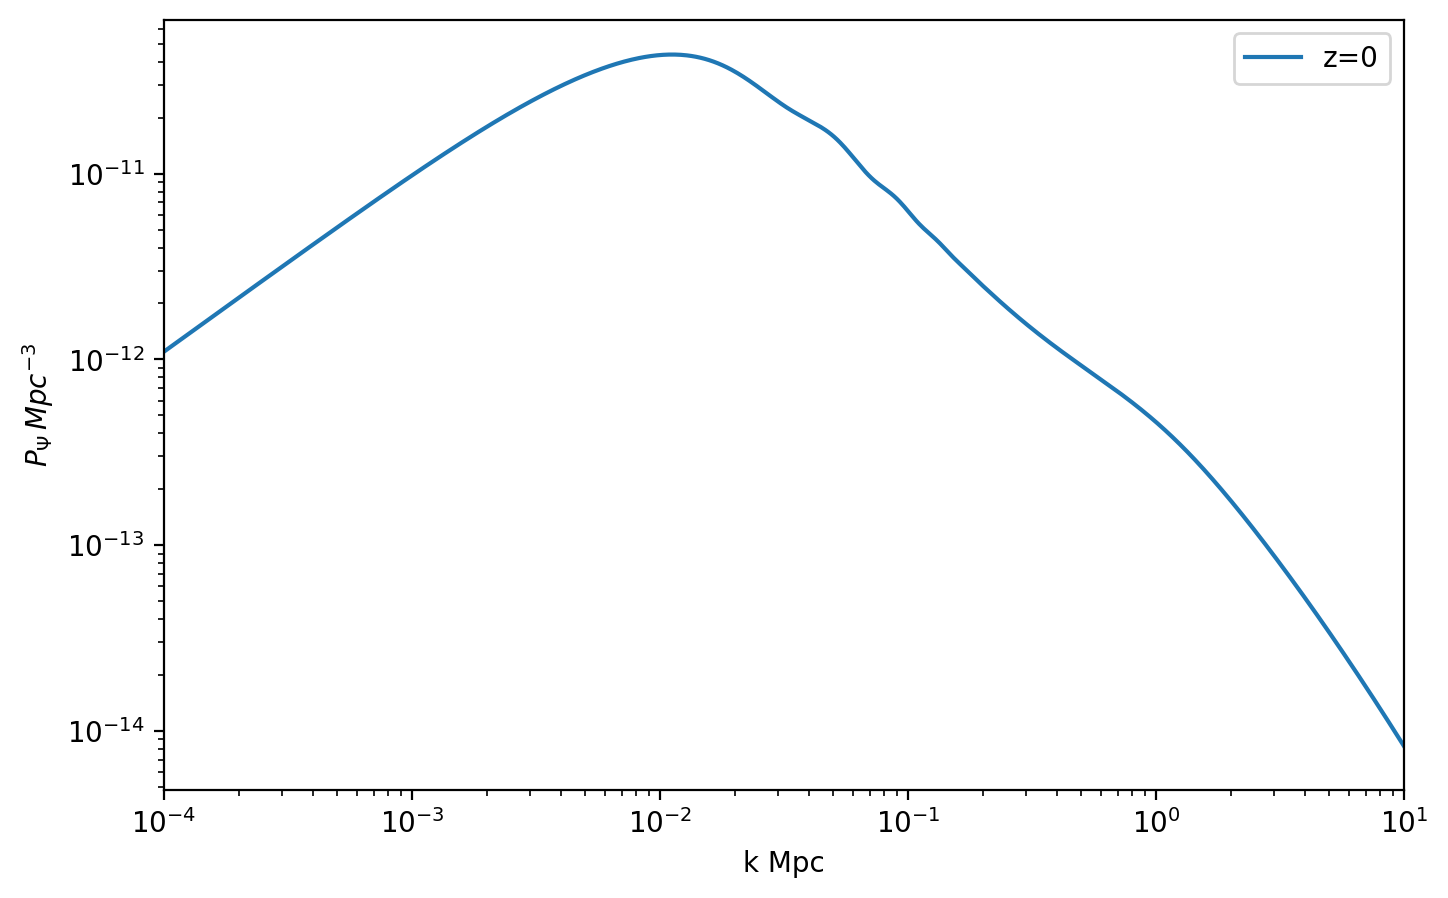

In [3]:
# Have a look at interpolated power spectrum results for a range of redshifts
# Expect linear potentials to decay a bit when Lambda becomes important, and change from non-linear growth
plt.figure(figsize=(8, 5))
k = np.exp(np.log(10) * np.linspace(-4, 2, 1000))
zplot = [0]
for z in zplot:
    plt.loglog(k, PK.P(z, k))
plt.xlim([1e-4, kmax])
plt.xlabel(r'k Mpc')
plt.ylabel(r'$P_\Psi\, Mpc^{-3}$')
plt.legend(['z=%s' % z for z in zplot])

The wavenumber $k$ typically spans the range:

$$
10^{-4} \leq k \leq 10^{2} \quad h/\mathrm{Mpc}
$$

This covers cosmological scales from the largest observable structures to small-scale nonlinear clustering.


In [5]:
# --- k values ---
# Log-spaced wavenumber values from 10^-4 to 10^2 (in h/Mpc)
k = np.exp(np.log(10) * np.linspace(-4, 2, 1024))  # 1024 points

# --- P(k) values ---
# Power spectrum at redshift z = 0 (today)
P_k = PK.P(0.0, k)  # z = 0 is present time


In [25]:
len(P_k)

1024

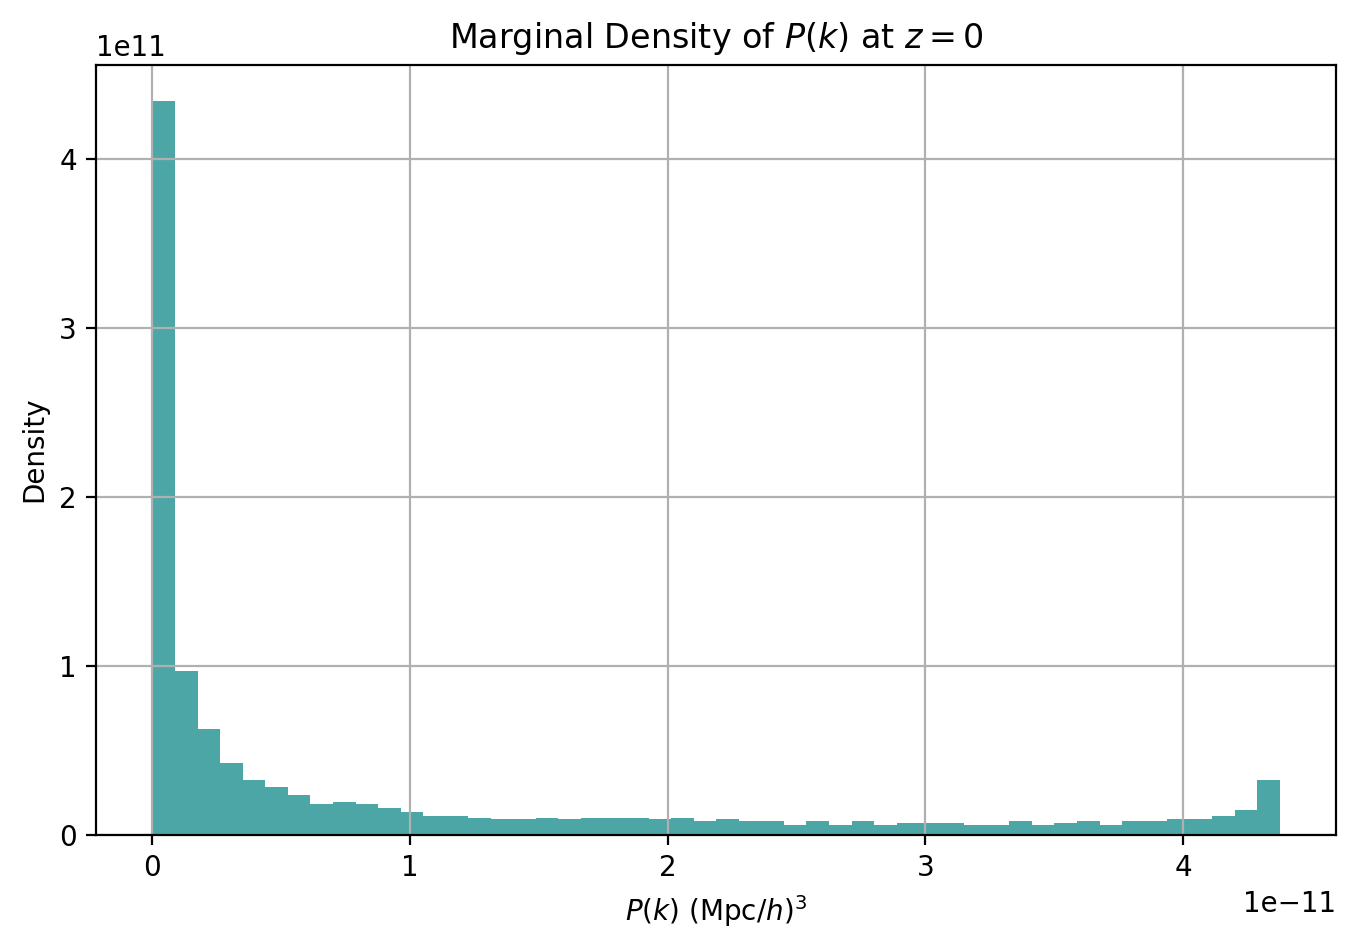

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(P_k, bins=50, density=True, alpha=0.7, color='teal')
plt.xlabel(r'$P(k)\ (\mathrm{Mpc}/h)^3$')
plt.ylabel('Density')
plt.title('Marginal Density of $P(k)$ at $z=0$')
plt.grid(True)
plt.show()


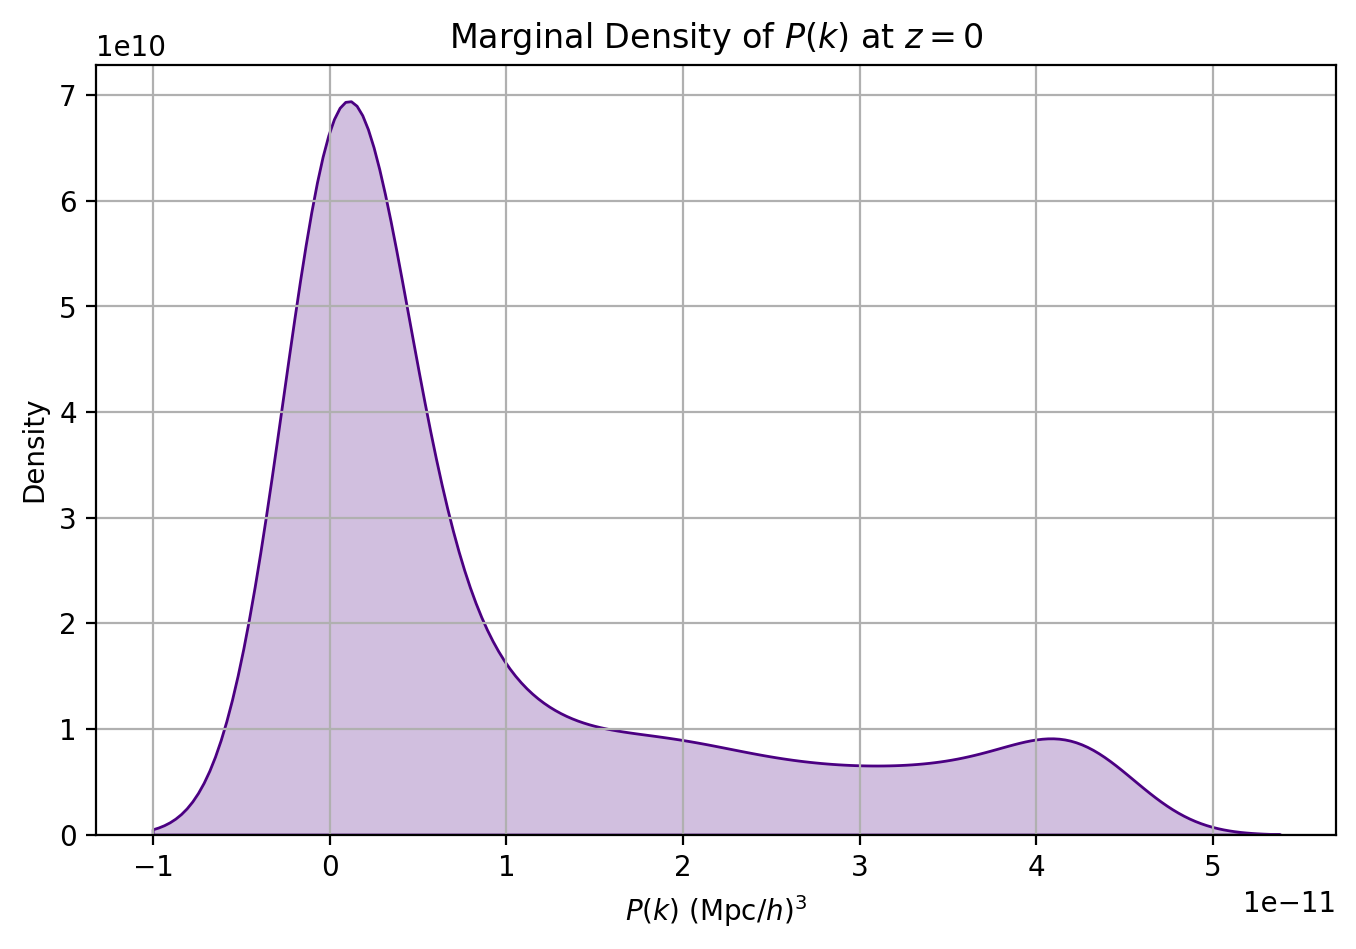

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.kdeplot(P_k, fill=True, color='indigo')
plt.xlabel(r'$P(k)\ (\mathrm{Mpc}/h)^3$')
plt.ylabel('Density')
plt.title('Marginal Density of $P(k)$ at $z=0$')
plt.grid(True)
plt.show()


Text(0.5, 0, '$\\log_{10}(P(k))\\ (\\mathrm{Mpc}/h)^3$')

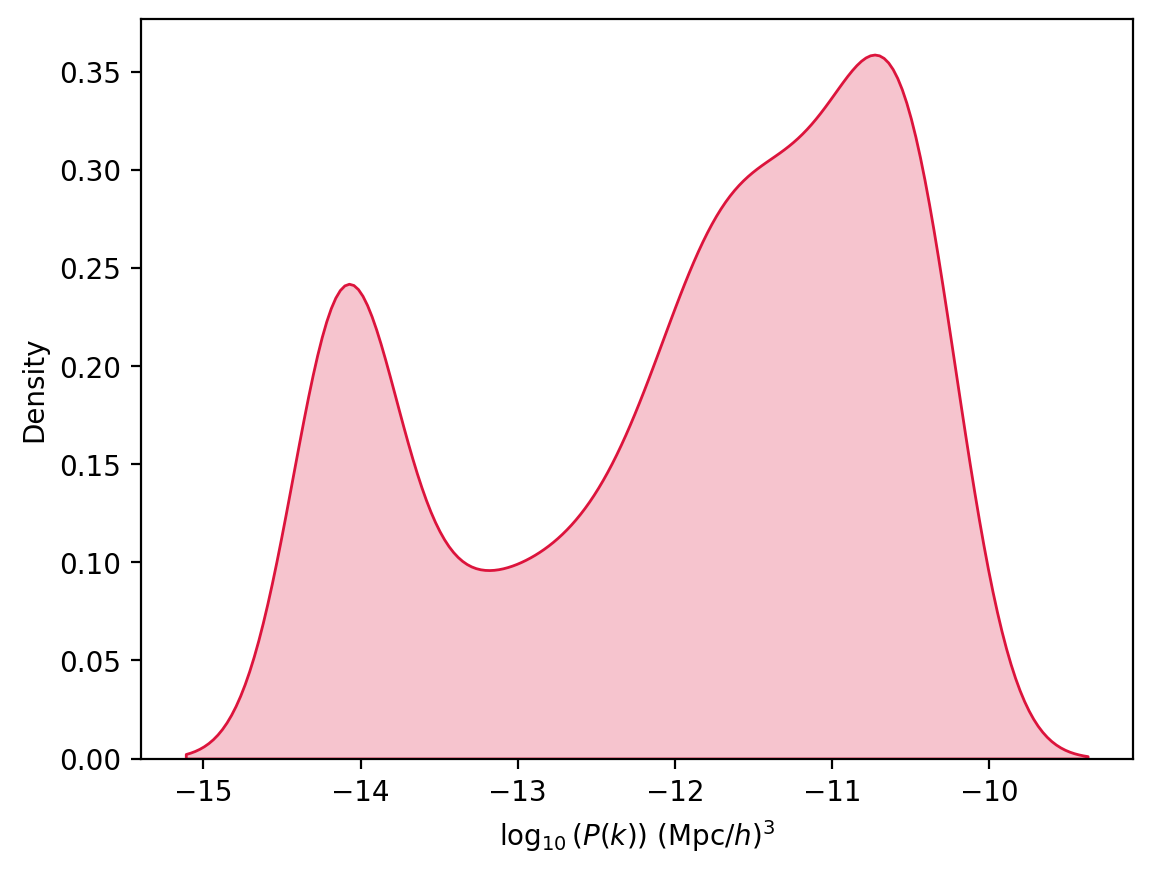

In [8]:
import numpy as np
log_P_k = np.log10(P_k)

# Then plot log_P_k instead of P_k
sns.kdeplot(log_P_k, fill=True, color='crimson')
plt.xlabel(r'$\log_{10}(P(k))\ (\mathrm{Mpc}/h)^3$')


We have the bimodal distribution of $log_{10}(P(k))$. 

# 2) Fitting the model 